# Purchase Rate Analysis

### Data Processing Steps
### - Remove accounts with no purchases from 2018 - 2022
### - Remove accounts with cumulative sales below 500.
### - Remove duplicate records and rows with missing critical information


In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('/Users/rachelyou/Downloads/cleaned_data_V3.csv')

# Remove those inactive account(without purchase records within the 7 years)
# Grouping by account and checking sales records by year
account_sales_by_year = df.pivot_table(
    index="C1AccountNo", columns="Year", values="annual_sales", aggfunc="sum", fill_value=0
)

# Count of years with zero sales per account
no_sales_count = (account_sales_by_year == 0).sum(axis=1)

# Counting accounts with no sales records for the past 7, 6, 5, and 4 years
no_sales_7_years = (no_sales_count == 7).sum()
no_sales_6_years = (no_sales_count == 6).sum()
no_sales_5_years = (no_sales_count == 5).sum()
no_sales_4_years = (no_sales_count == 4).sum()

no_sales_7_years, no_sales_6_years, no_sales_5_years, no_sales_4_years



(np.int64(51), np.int64(18814), np.int64(6209), np.int64(2780))

In [2]:
# Step 1: Remove accounts with no purchases in the last 5 years (2018-2022)
no_purchase_accounts_2018_2022 = df[(df["Year"] >= 2018) & (df["Year"] <= 2022)]
accounts_no_purchases_2018_2022 = no_purchase_accounts_2018_2022.groupby("C1AccountNo")["annual_sales"].sum()
no_purchase_accounts_2018_2022_list = accounts_no_purchases_2018_2022[accounts_no_purchases_2018_2022 == 0].index.tolist()
filtered_df = df[~df["C1AccountNo"].isin(no_purchase_accounts_2018_2022_list)]

# Step 2: Remove low-volume accounts with cumulative sales below 500
low_volume_accounts = filtered_df.groupby("C1AccountNo")["annual_sales"].sum()
low_volume_accounts_list = low_volume_accounts[low_volume_accounts < 500].index.tolist()
filtered_df = filtered_df[~filtered_df["C1AccountNo"].isin(low_volume_accounts_list)]

# Step 3: Drop duplicates and rows with missing values in critical columns
filtered_df = filtered_df.drop_duplicates()
filtered_df = filtered_df.dropna(subset=["C1AccountNo", "Territory"])
original_accounts = df["C1AccountNo"].nunique()
filtered_accounts = filtered_df["C1AccountNo"].nunique()
deleted_accounts = original_accounts - filtered_accounts

print("Number of accounts deleted:", deleted_accounts)

Number of accounts deleted: 8715


Those inactive accounts affect the calculation of the purchase rate. It would be more appropriate to focus on those active client who actively made purchases.

## Regional Purchase Rate Analysis
### Annual Purchase Rate


In [3]:
total_sales_filtered = filtered_df["annual_sales"].sum()
filtered_df["annual_purchase_rate"] = (filtered_df["annual_sales"] / total_sales_filtered) * 100
annual_purchase_rate_filtered = filtered_df.groupby("Territory")["annual_purchase_rate"].sum().reset_index()
annual_purchase_rate_filtered


,Territory,annual_purchase_rate
0,Central,21.658052
1,International,1.228095
2,Midwest,14.132017
3,Northeast,19.138093
4,South,20.797987
5,Special,0.007575
6,Unknown,3.439462
7,West,19.598719


### Visualization: Annual Purchase Rate by Regions

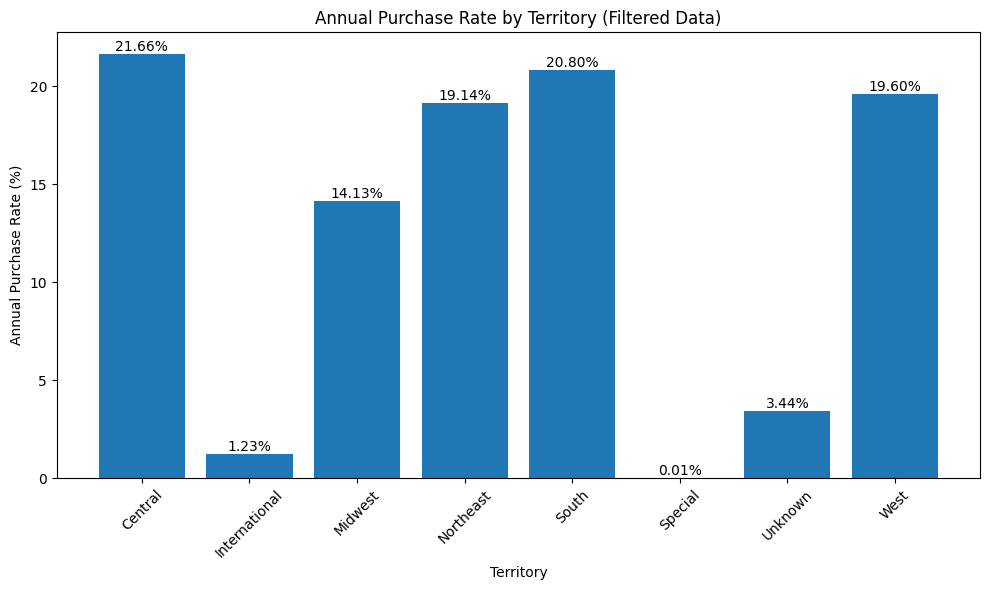

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
bars = plt.bar(annual_purchase_rate_filtered["Territory"], annual_purchase_rate_filtered["annual_purchase_rate"])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}%', ha='center', va='bottom')

plt.xlabel("Territory")
plt.ylabel("Annual Purchase Rate (%)")
plt.title("Annual Purchase Rate by Territory (Filtered Data)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Quarterly Purchase Rate Analysis

In [15]:
total_q_sales = {
    "q1": filtered_df["q1_sales"].sum(),
    "q2": filtered_df["q2_sales"].sum(),
    "q3": filtered_df["q3_sales"].sum(),
    "q4": filtered_df["q4_sales"].sum(),
}

quarterly_sales_df = pd.DataFrame(list(total_q_sales.items()), columns=["Quarter", "Total_Sales"])

total_sales_sum = sum(total_q_sales.values())
quarterly_sales_df["Purchase_Rate"] = (quarterly_sales_df["Total_Sales"] / total_sales_sum) * 100

quarterly_sales_df


,Quarter,Total_Sales,Purchase_Rate
0,q1,91466915.77,39.080024
1,q2,63873509.07,27.290504
2,q3,39679626.21,16.953461
3,q4,39030254.86,16.676011


## Quarterly Purchase Rate by Regions

In [16]:
quarterly_territory_sales = filtered_df.groupby("Territory")[["q1_sales", "q2_sales", "q3_sales", "q4_sales"]].sum()

quarterly_territory_sales["Total_Sales"] = quarterly_territory_sales.sum(axis=1)
for quarter in ["q1_sales", "q2_sales", "q3_sales", "q4_sales"]:
    quarterly_territory_sales[f"{quarter}_rate"] = (quarterly_territory_sales[quarter] / quarterly_territory_sales["Total_Sales"]) * 100

quarterly_territory_sales = quarterly_territory_sales.drop(columns=["Total_Sales"])

quarterly_territory_sales.reset_index()


,Territory,q1_sales,q2_sales,q3_sales,q4_sales,q1_sales_rate,q2_sales_rate,q3_sales_rate,q4_sales_rate
0,Central,19527308.91,13385927.98,9173902.40,8603598.43,38.522440,26.407049,18.097788,16.972723
1,International,1097780.75,753582.32,487143.91,535854.20,38.192164,26.217384,16.947902,18.642549
2,Midwest,13629923.09,8782672.69,5071090.09,5592343.25,41.207858,26.552984,15.331617,16.907541
3,Northeast,17146307.44,13074375.10,7409959.84,7162121.84,38.279190,29.188587,16.542761,15.989462
4,South,18785279.77,13196148.86,8511785.95,8184538.03,38.591099,27.109199,17.485988,16.813714
5,Special,4507.48,3946.45,5778.99,3496.13,25.424261,22.259794,32.596163,19.719782
6,Unknown,2953420.52,2066505.88,1620914.99,1409229.22,36.688132,25.670655,20.135413,17.505799
7,West,18322387.81,12610349.79,7399050.04,7539073.76,39.943413,27.490981,16.130175,16.435431


## Visualization: Quarterly Purchase Rate Performance

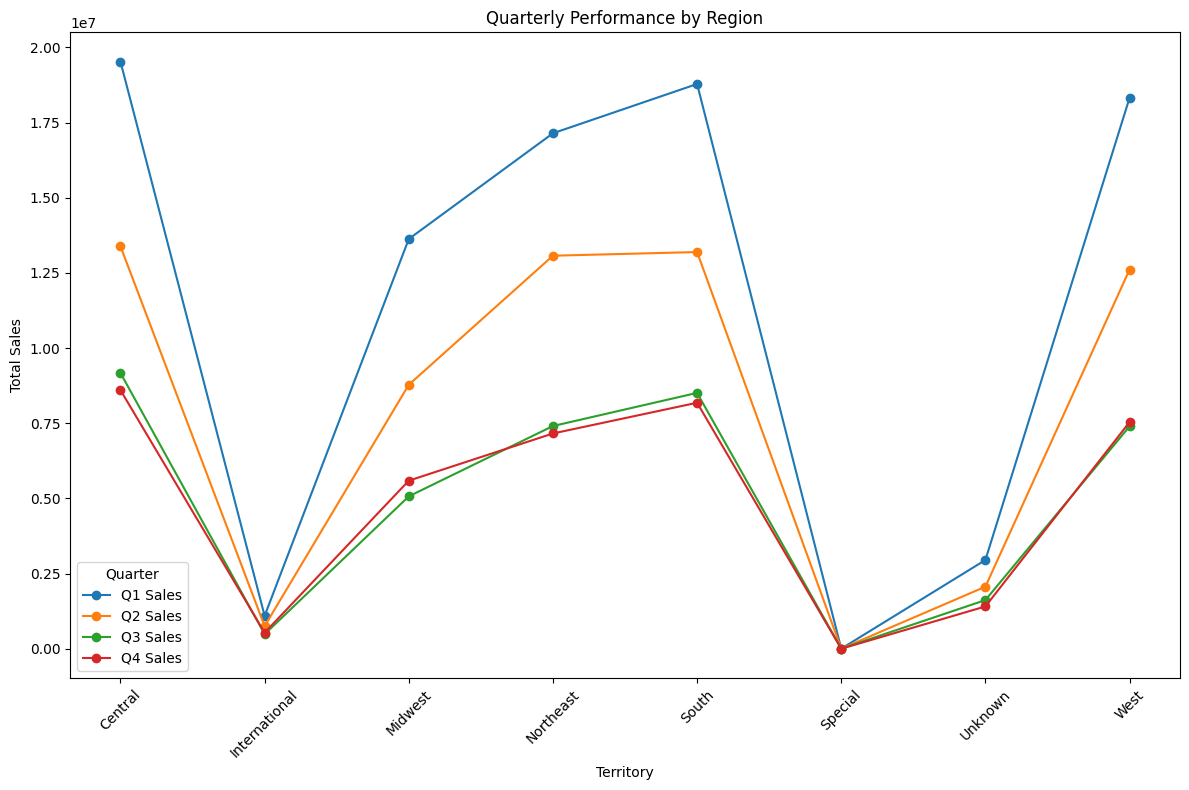

In [19]:
territories = quarterly_territory_sales.index
q1_sales = quarterly_territory_sales["q1_sales"]
q2_sales = quarterly_territory_sales["q2_sales"]
q3_sales = quarterly_territory_sales["q3_sales"]
q4_sales = quarterly_territory_sales["q4_sales"]
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(territories, q1_sales, marker='o', label="Q1 Sales")
ax.plot(territories, q2_sales, marker='o', label="Q2 Sales")
ax.plot(territories, q3_sales, marker='o', label="Q3 Sales")
ax.plot(territories, q4_sales, marker='o', label="Q4 Sales")
ax.set_xlabel("Territory")
ax.set_ylabel("Total Sales")
ax.set_title("Quarterly Performance by Region")
ax.legend(title="Quarter")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



### Seasonal Trends Across Territories


- **Overall Peaks**: Most territories experience peak sales in **Q1**, likely due to post-holiday demand or new fiscal budgets.
- **Declines in Q3 and Q4**: Sales generally dip in **Q3** and **Q4**, suggesting a slow-down toward year-end, potentially due to budget limits or year-end planning.

#### Territory-Specific Patterns
- **Central, Midwest, South, and West**: Strong **Q1** sales followed by steady declines through **Q4**, indicating seasonally driven demand.
- **International and Unknown**: Show a more even sales distribution, with **Q1** leading but less prominently, indicating stable year-round demand.
- **Special Territory**: Unusual trend with higher sales in **Q3**, suggesting unique demand conditions.

#### Strategic Insights
- **Boost Marketing in Q1/Q2**: Prioritize promotions in Q1/Q2 where most territories see peak demand.
- **Allocate Resources**: Focus inventory and resources on territories with high Q1 demand.
- **Enhance Off-Peak Strategies**: Develop sales tactics for Q3/Q4 to balance seasonal dips in performance.

## Predictive Analysis by Using the Random Forest

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

best_rf_model = RandomForestRegressor(
    n_estimators=500,
    min_samples_split=15,
    min_samples_leaf=10,
    max_features='sqrt',
    max_depth=10,
    random_state=42
)

best_rf_model.fit(X_train, y_train)

best_rf_forecast = best_rf_model.predict(X_test)

optimized_rf_mae = mean_absolute_error(y_test, best_rf_forecast)
optimized_rf_mse = mean_squared_error(y_test, best_rf_forecast)

print(f"Optimized Random Forest MAE: {optimized_rf_mae}")
print(f"Optimized Random Forest MSE: {optimized_rf_mse}")


Optimized Random Forest MAE: 1746.494452483101
Optimized Random Forest MSE: 32210649.901163004


## Event and Purchase Rate Analysis

### Event Frequency and the Regional Purchase Rate Analysis

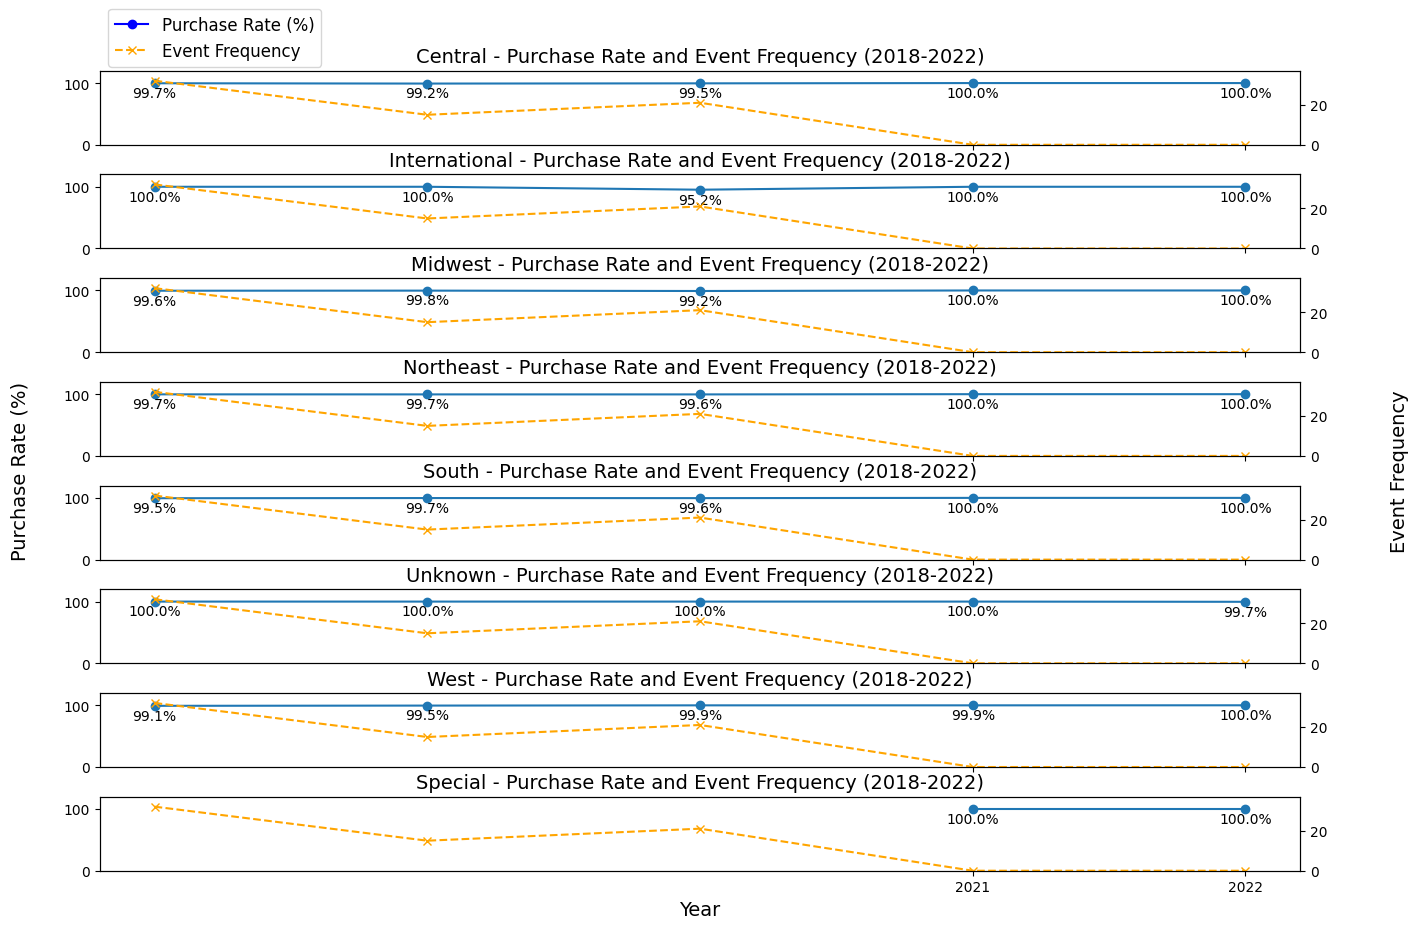

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Load data
df = pd.read_csv('/Users/rachelyou/Downloads/cleaned_data_V3.csv')
event_data = pd.read_excel('/Users/rachelyou/Desktop/event.xlsx')

# Rename columns in event_data
event_data.columns = ['Event', '2018', '2019', '2020', '2021', '2022', '2023']

# Calculate event frequency per year
event_data_counts = event_data.iloc[1:].notnull().sum()[['2018', '2019', '2020', '2021', '2022']]
event_frequency_by_year = event_data_counts.reset_index()
event_frequency_by_year.columns = ["Year", "event_frequency"]
event_frequency_by_year["Year"] = event_frequency_by_year["Year"].astype(int)

# Filter data for years 2018-2022
filtered_df = df[(df["Year"] >= 2018) & (df["Year"] <= 2022)]

# Calculate total and purchased accounts per region and year
filtered_df_corrected = filtered_df.groupby(["Year", "Territory"]).agg(
    total_accounts=('C1AccountNo', 'nunique'),  
    purchased_accounts=('C1AccountNo', lambda x: filtered_df.loc[x.index, 'annual_sales'].gt(0).sum())  
).reset_index()

# Calculate purchase rate and cap at 100%
filtered_df_corrected["purchase_rate"] = (
    filtered_df_corrected["purchased_accounts"] / filtered_df_corrected["total_accounts"]
) * 100
filtered_df_corrected["purchase_rate"] = filtered_df_corrected["purchase_rate"].clip(upper=100)

# Merge with event frequency data
regional_purchase_rate_with_event_freq = pd.merge(filtered_df_corrected, event_frequency_by_year, on="Year")

# Plot regional purchase rate and event frequency on separate subplots
regions = regional_purchase_rate_with_event_freq["Territory"].unique()
fig, axes = plt.subplots(len(regions), 1, figsize=(15, 10), sharex=True)

for i, region in enumerate(regions):
    region_data = regional_purchase_rate_with_event_freq[regional_purchase_rate_with_event_freq["Territory"] == region]
    ax = axes[i]
    
    ax.plot(region_data["Year"], region_data["purchase_rate"], marker='o', label="Purchase Rate (%)")
    ax.set_ylim(0, 120)
    ax.set_title(f"{region} - Purchase Rate and Event Frequency (2018-2022)", fontsize=14)
    ax.set_xticks(region_data["Year"].unique())

    for j, row in region_data.iterrows():
        ax.annotate(f"{row['purchase_rate']:.1f}%", 
                    (row["Year"], row["purchase_rate"]),
                    textcoords="offset points", 
                    xytext=(0, -10),  
                    ha='center', fontsize=10)

    ax2 = ax.twinx()
    ax2.plot(event_frequency_by_year["Year"], 
             event_frequency_by_year["event_frequency"], 
             color='orange', marker='x', linestyle='--')
    ax2.set_ylim(0, event_frequency_by_year["event_frequency"].max() + 5)
fig.text(0.04, 0.5, 'Purchase Rate (%)', va='center', rotation='vertical', fontsize=14)
fig.text(0.96, 0.5, 'Event Frequency', va='center', rotation='vertical', fontsize=14)
axes[-1].set_xlabel("Year", fontsize=14)

legend_elements = [
    Line2D([0], [0], color='blue', marker='o', linestyle='-', label='Purchase Rate (%)'),
    Line2D([0], [0], color='orange', marker='x', linestyle='--', label='Event Frequency')
]
fig.legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(0.1, 0.97), fontsize=12)

plt.subplots_adjust(hspace=0.4, top=0.9, left=0.1, right=0.9, bottom=0.1)
plt.show()


### Quarterly Purchase Rate and the Event Frequency

Quarterly Purchase Rate and Event Frequency Analysis
    Year   Quarter  total_accounts  purchased_accounts  \
0   2018  Q1_sales            5699                2937   
1   2018  Q2_sales            5699                2804   
2   2018  Q3_sales            5699                2320   
3   2018  Q4_sales            5699                2630   
4   2019  Q1_sales            6200                3334   
5   2019  Q2_sales            6200                3055   
6   2019  Q3_sales            6200                2754   
7   2019  Q4_sales            6200                2879   
8   2020  Q1_sales            5572                3540   
9   2020  Q2_sales            5572                1870   
10  2020  Q3_sales            5572                2250   
11  2020  Q4_sales            5572                2668   
12  2021  Q1_sales            5876                2940   
13  2021  Q2_sales            5876                2910   
14  2021  Q3_sales            5876                2712   
15  2021  Q4_sales 

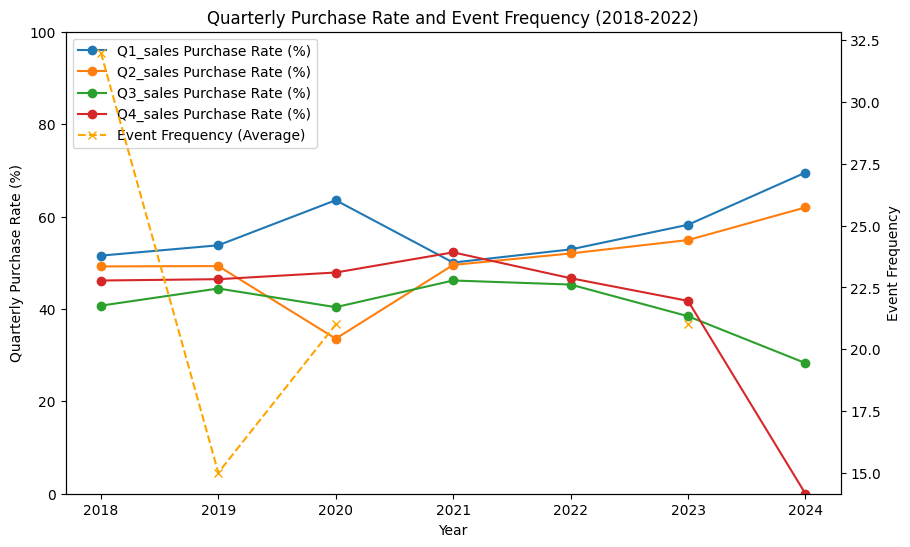

In [18]:
event_data.columns = ['Event', '2018', '2019', '2020', '2021', '2022', '2023']

df['Q1_sales'] = df[['Jan', 'Feb', 'Mar']].sum(axis=1)
df['Q2_sales'] = df[['Apr', 'May', 'Jun']].sum(axis=1)
df['Q3_sales'] = df[['Jul', 'Aug', 'Sep']].sum(axis=1)
df['Q4_sales'] = df[['Oct', 'Nov', 'Dec']].sum(axis=1)

df_long = df.melt(
    id_vars=["Year", "C1AccountNo", "Territory"],
    value_vars=["Q1_sales", "Q2_sales", "Q3_sales", "Q4_sales"],
    var_name="Quarter",
    value_name="Quarterly_sales"
)

df_long['Purchased'] = df_long['Quarterly_sales'] > 0

quarterly_purchase_data = df_long.groupby(["Year", "Quarter"]).agg(
    total_accounts=('C1AccountNo', 'nunique'),
    purchased_accounts=('Purchased', 'sum')
).reset_index()

quarterly_purchase_data["quarterly_purchase_rate"] = (
    quarterly_purchase_data["purchased_accounts"] / quarterly_purchase_data["total_accounts"]
) * 100

event_data.rename(columns={'Event': 'Event_Description'}, inplace=True)

quarterly_event_data = event_data.iloc[1:].melt(
    var_name="Year", value_name="Event"
).dropna()
quarterly_event_data = quarterly_event_data[quarterly_event_data['Year'].apply(lambda x: x.isnumeric())]
quarterly_event_data['Year'] = quarterly_event_data['Year'].astype(int)
quarterly_event_counts = quarterly_event_data.groupby(["Year"]).size().reset_index(name="event_frequency")
quarterly_analysis = pd.merge(quarterly_purchase_data, quarterly_event_counts, on="Year", how="left")
print("Quarterly Purchase Rate and Event Frequency Analysis")
print(quarterly_analysis)

fig, ax1 = plt.subplots(figsize=(10, 6))

for quarter in quarterly_analysis['Quarter'].unique():
    data = quarterly_analysis[quarterly_analysis['Quarter'] == quarter]
    ax1.plot(data["Year"], 
             data["quarterly_purchase_rate"], 
             marker='o', label=f"{quarter} Purchase Rate (%)")
    
ax1.set_xlabel("Year")
ax1.set_ylabel("Quarterly Purchase Rate (%)")
ax1.set_ylim(0, 100)
ax1.tick_params(axis='y')
ax1.set_title("Quarterly Purchase Rate and Event Frequency (2018-2024)")

ax2 = ax1.twinx()
ax2.plot(quarterly_analysis["Year"].unique(), 
         quarterly_analysis.groupby("Year")["event_frequency"].mean(), 
         color='orange', marker='x', linestyle='--', label="Event Frequency (Average)")
ax2.set_ylabel("Event Frequency")
ax2.tick_params(axis='y')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper left")

plt.show()
